In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36599")
client

<Client: 'tcp://127.0.0.1:36599' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
# import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline
from scipy.sparse import coo_matrix, linalg

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

# Old elliptic solver

In [8]:
def bernoulli(f, g_w, g_e, g_n, g_s, hx2, hy2): 
    # RHS of elliptic equation, boundary conditions, grid spacing at grid points (XG,YG).
    # hx2 = hx2.to_numpy()
    # hy2 = hy2.to_numpy()
    f = f.to_numpy()
    [n, m] = f.shape #lengths of j and i

    # separate points for 4 boundaries and interior
    bc_w = [0] 
    bc_e = [m-1]
    bc_i = bc_w + bc_e # boundaries in west and east
    interior_i = [i for i in range(1,m-1)]

    bc_n = [n-1]
    bc_s = [0]
    bc_j = bc_s + bc_n # boundaries in north and south 
    interior_j = [j for j in range(1,n-1)]

  
    # construct RHS with boundary conditions

    g_bc = np.zeros([n,m])
    g_bc[:,bc_w] = (g_w * dxGG ** -1).isel(XG = bc_w).to_numpy()
    g_bc[:,bc_e] = (g_e * dxGG ** -1).isel(XG = bc_e).to_numpy()

    g_bc[bc_n,:] = (g_n * dyGG ** -1).isel(YG = bc_n).to_numpy()
    g_bc[bc_s,:] = (g_s * dyGG ** -1).isel(YG = bc_s).to_numpy()

    b = (f - g_bc).reshape(m*n)

    # entries for diagnol matrix D_n(m,m)
    # coefficients for Bij
    cij_x = -2 * hx2
    cij_x[:,bc_i] = - hx2[:,bc_i] #entries for western/eastern boundaries are replaced. these are where the boundary condition should be added to b later
    cij_y = -2 * hy2
    cij_y[bc_j,:] = - hy2[bc_j,:] 
    cij = cij_x + cij_y

    # chop the boundaries for the square domain. 
    cip = hx2[:,bc_w+interior_i] #B_i+1,j 
    cim = hx2[:,interior_i+bc_e] #B_i-1,j

    diagnols = np.append(np.append(cij.reshape(m*n), # along row then column
                              cip.reshape((m-1)*n)
                             ),
                    cim.reshape((m-1)*n)
                   )

    # indices of the entries in A
    r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
    c_cij = r_cij #B_ij

    range_ip = [i + 1 for i in (bc_w + interior_i)]
    r_cip = [m*j + i for j in range(0,n) for i in (bc_w + interior_i)], 
    c_cip = [m*j + i for j in range(0,n) for i in range_ip] #B_i+1,j 

    range_im = [i - 1 for i in (interior_i + bc_e)]
    r_cim = [m*j + i for j in range(0,n) for i in (interior_i + bc_e)], 
    c_cim = [m*j + i for j in range(0,n) for i in range_im] #B_i-1,j

    rows = np.append(np.append(r_cij, r_cip), r_cim)
    cols = np.append(np.append(c_cij, c_cip), c_cim)

    # generate sparse matrix D
    D = coo_matrix((diagnols, (rows, cols)), shape=(m*n,m*n)).tocsr()

    # entries for identity matrices
    cjp = hy2[bc_s + interior_j,:] #B_i,j+1
    cjm = hy2[interior_j + bc_n,:] #B_i,j-1

    Is = np.append(cjp.reshape((n-1)*m), cjm.reshape((n-1)*m))

    # indices of the entries in A
    range_ip = [j + 1 for j in (bc_s + interior_j)]
    r_cjp = [m*j + i for j in (bc_s + interior_j) for i in range(0,m)]
    c_cjp = [m*j + i for j in range_ip for i in range(0,m)]

    range_im = [j - 1 for j in (interior_j + bc_n)]
    r_cjm = [m*j + i for j in (interior_j + bc_n) for i in range(0,m)]
    c_cjm = [m*j + i for j in range_im for i in range(0,m)]

    rows_i = np.append(r_cjp, r_cjm)
    cols_i = np.append(c_cjp, c_cjm)

    I = coo_matrix((Is, (rows_i, cols_i)), shape=(m*n,m*n)).tocsr()
    A = D + I

    sol, istop, itn, r1norm = linalg.lsqr(A,b)[:4]

    return sol.reshape(n,m), istop, itn, r1norm

In [14]:
# boundaries of mode water with different threshold of PV

Pi_thres_range = [0.25e-9] #[0.22e-9, 0.25e-9, 0.28e-9] # threshold of low PV pool
for Pi_thres in Pi_thres_range:
    year = years[0]
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,1],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
    XG_sub = [279, 326]
    YG_sub = [24, 41]
    delta_isub = [17, 26] # buoyancy = -0.245, -0.254
    
    for itime in ntimes[0]:     
        dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                                   % (year,itime))
                          ).reset_coords(drop=True).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                                                       ).chunk({'YG':ychunk,'XG':xchunk})
        if itime == ntimes[0,0]:
            Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                             YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
            buoyancy = - grav * Pi.delta_outer * rho0**-1
        else:
            Pi = xr.concat([Pi,
                            dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                        YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                           ],'ntime')
    
    Pi.coords['ntime'] = ('ntime',range(73))   

    Pi_mean = Pi.where(Pi>0).mean('ntime',skipna=True) 
    
    count = 0
    
    for d_index in range(delta_isub[0],delta_isub[1]): 
        mask_new, mask_b_new = contour_mask(Pi_mean.isel(delta_outer = d_index), Pi_thres)
        if count == 0:
            mask = mask_new
            mask_b = mask_b_new
        else:
            mask = xr.concat([mask, mask_new], dim = 'delta_outer')
            mask_b = xr.concat([mask_b, mask_b_new], dim = 'delta_outer')

        count += 1

#         dsave = mask.to_dataset(name='mask').chunk({'YG':ychunk,'XG':xchunk})   
#         dsave['mask_b'] = mask_b.chunk({'YG':ychunk,'XG':xchunk})   

#         dsave.to_zarr(op.join(savedir,twadir,'run%4d/PV_mask_%2d/%010d/' 
#                                                 % (year,Pi_thres *1e11,itime)), mode='w')
#         dsave.close()

        
#             print(mask)


2
1
2
2
3
3
4
4
3


In [ ]:
dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})   
dsave['mask_b'] = mask_b.chunk({'YG':ychunk,'XG':xchunk})   

dsave.to_zarr(op.join(savedir,twadir,'run%4d/meanPV_mask_%2d/' 
                                        % (year,Pi_thres *1e11)), mode='w')
dsave.close()


In [6]:
year = years[0]
XG_sub = [280, 345]
YG_sub = [23, 42]

for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    if itime == ntimes[0,0]:
        Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                         YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
        buoyancy = - grav * Pi.delta_outer * rho0**-1
    else:
        Pi = xr.concat([Pi,
                        dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                    YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                       ],'ntime')

Pi.coords['ntime'] = ('ntime',range(73))   

# time-mean of each months
Pi_mean = Pi.where(Pi>0).mean('ntime',skipna=True) 
Pi_summer = (Pi.where(Pi>0).sel(ntime = range(36,55))).mean('ntime',skipna=True) 
Pi_winter = (Pi.where(Pi>0).sel(ntime = range(0,18))).mean('ntime',skipna=True) 
Pi_winter2 = (Pi.where(Pi>0).sel(ntime = range(67,73))).mean('ntime',skipna=True) 

In [148]:

# construct RHS with boundary conditions
# fill in the boundaries of the domain
g_bc = np.zeros([n,m])
g_bc[:,bc_w] = (g_w * dxGG_r.dxGG_r).isel(XG = bc_w).to_numpy()
g_bc[:,bc_e] = (g_e * dxGG_r.dxGG_r).isel(XG = bc_e).to_numpy()

g_bc[bc_n,:] = (g_n * dyGG_r.dyGG_r).isel(YG = bc_n).to_numpy()
g_bc[bc_s,:] = (g_s * dyGG_r.dyGG_r).isel(YG = bc_s).to_numpy()

# consider the lands
g = (g_w * hx_w + g_e * hx_e + g_n * hy_n +g_s * hy_s).fillna(0).to_numpy()


NameError: name 'g_w' is not defined

# Elliptic solver

The elliptic solver solves Bernoulli in the domain masked under a given PV threshold. The threshold of PV is taken as 1 so that all PV within the domain has been considered.

In [6]:
def mask_filter(mask_tmp):
        XG_len = len(mask_tmp.XG.values)
        YG_len = len(mask_tmp.YG.values)

        d1_tmp = mask_tmp.isel(XG = slice(0, XG_len-1)).diff('XG')
        d2_tmp = mask_tmp.isel(XG = slice(1, XG_len)).diff('XG', label = 'lower')


        d3_tmp = mask_tmp.isel(YG = slice(0, YG_len-1)).diff('YG')
        d4_tmp = mask_tmp.isel(YG = slice(1, YG_len)).diff('YG', label = 'lower')


        return xr.where((xr.where(np.abs(d1_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) + 
                       xr.where(np.abs(d1_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0)
                      )>0, 1, 0)

def contour_mask(Pi, Pi_thres):
        # cells that are within the pool are marked. 
        mask_tmp = xr.where(Pi.where(Pi >= 0) <= Pi_thres, 1, 0)  # ignore negative PV


        mask = mask_filter(mask_tmp)
        i = 0
        while ((mask - mask_tmp).any() !=0):
            if (i > 4):
                break
            else:
                mask_tmp = mask
                mask = mask_filter(mask_tmp)
                i+=1
        print(i)        

        # within the domain, the boundaries and outward corners are found.
        d1 = mask.diff('XG')
        d2 = mask.diff('XG', label = 'lower')

        mask_w = xr.where(xr.where(d1 == 1, 1, 0) + xr.where(d2 == 0, 1, 0) == 2, 1, 0)
        mask_e = xr.where(xr.where(d2 == -1, 1, 0) + xr.where(d1 == 0, 1, 0) == 2, 2, 0)

        d3 = mask.diff('YG')
        d4 = mask.diff('YG', label = 'lower')

        mask_s = xr.where(xr.where(d3 == 1, 1, 0) + xr.where(d4 == 0, 1, 0) == 2, 3, 0)
        mask_n = xr.where(xr.where(d4 == -1, 1, 0) + xr.where(d3 == 0, 1, 0) == 2, 6, 0)

        
        # update masks for boundaries and interiors
        mask_b = mask_w + mask_e  + mask_s + mask_n
        mask_int = (xr.where(mask == 1, 9, 0) + mask_b).where(xr.where(mask == 1, 9, 0) + mask_b <= 9, 0)
        
        # inward corners
        mask_tmp2 = mask_b + mask_int

        d1_2 = mask_tmp2.diff('XG')
        d2_2 = mask_tmp2.diff('XG', label = 'lower')

        d3_2 = mask_tmp2.diff('YG')
        d4_2 = mask_tmp2.diff('YG', label = 'lower')

        c_sw = xr.where(d3_2 == 8, 1, 0) + xr.where(d1_2 == 6, 1, 0) 
        c_nw = xr.where(d4_2 == -8, 1, 0) + xr.where(d1_2 == 3, 1, 0) 
        c_se = xr.where(d3_2 == 7, 1, 0) + xr.where(d2_2 == -6, 1, 0) 
        c_ne = xr.where(d4_2 == -7, 1, 0) + xr.where(d2_2 == -3, 1, 0) 
        corner = (xr.where(c_sw == 2, 10, 0) + xr.where(c_nw == 2, 11, 0) +
                 xr.where(c_se == 2, 12, 0) + xr.where(c_ne == 2, 13, 0))
        
       
        mask_b_new = mask_b + corner 
        
      
        mask_int = (mask_int + corner).where(mask_int + corner == 9,0) 
        mask_new = mask_int + mask_b_new
        
        # on the borders of the domain, the boundaries are found
        [n,m] = mask_new.shape
        bdr = np.ones([n,m])
        bdr[0,:] = 3/9
        bdr[n-1,:] = 6/9
        bdr[:,0] = 1/9
        bdr[:,m-1] = 2/9
        # mask_b_new = mask_b_new * bdr
        mask_new = mask_new * bdr
        
        return mask_new, mask_b_new

In [7]:
def bernoulli(f, g_w, g_e, g_n, g_s, mask): 
    
    # Select a subdomain based on the mask of PV
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=ntimes[0,0],
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))
    grid = Grid(ds, periodic=['X'])

    # grid spacings 
    dxGG_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dxC, 'Y') ** -1).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dxGG_r')])
    dyGG_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dyC, 'X') ** -1).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dyGG_r')])
    dxGG2_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dxC, 'Y') ** -2).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dxGG2_r')])
    dyGG2_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dyC, 'X') ** -2).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dyGG2_r')])
    ds.close()

    # grid spacing at masked points 
    hx_w = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 7,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 1,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 4,0)
           )

    hx_e = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 8,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 2,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 5,0)
           )

    hy_n = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 7,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 6,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 8,0)
           )

    hy_s = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 4,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 3,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 5,0)
           )

    hx2 = dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask >0, 0)

    hy2 = dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask >0, 0)

    # coefficients of 5 elements C_ij, C_i+1,j, C_i-1,j, C_i,j+1, C_i,j-1
    cij_x = - hx2
    for index in [6,9,3,10,11,12,13]: # - 2/dx^2 for interiors
        cij_x = cij_x - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) 
    cij_y = - hy2
    for index in [1,9,2,10,11,12,13]: # - 2/dy^2 for interiors
        cij_y = cij_y - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) 
    cij = cij_x + cij_y

    cip = hx2
    for index in [8,2,5]:
        cip = cip - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i+1,j on eastern boundaries
    cim = hx2
    for index in [7,1,4]:
        cim = cim - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i-1,j on western boundaries
    cjp = hy2
    for index in [7,6,8]:
        cjp = cjp - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j+1 on northern boundaries
    cjm = hy2
    for index in [4,3,5]:
        cjm = cjm - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j-1 on southern boundaries

    # locations of 5 elements
    [n, m] = f.shape
    r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
    c_cij = r_cij 

    r_cip = [m*j + i for j in range(0,n) for i in range(0,m-1)], 
    c_cip = [m*j + i + 1 for j in range(0,n) for i in range(0,m-1)] 

    r_cim = [m*j + i for j in range(0,n) for i in range(1,m)], 
    c_cim = [m*j + i - 1 for j in range(0,n) for i in range(1,m)] 

    r_cjp = [m*(j+1) + i for j in range(0,n-1) for i in range(0,m)]
    c_cjp = [m*j + i for j in range(0,n-1) for i in range(0,m)]

    r_cjm = [m*(j-1) + i for j in range(1,n) for i in range(0,m)]
    c_cjm = [m*j + i for j in range(1,n) for i in range(0,m)]

    # generate sparse matrix A
    diag = np.append(np.append(cij.to_numpy().reshape(m*n), # along row then column
                                  (cip.to_numpy())[:,0:m-1].reshape((m-1)*n)
                                 ),
                        (cim.to_numpy())[:,1:m].reshape((m-1)*n)
                       )
    r_D = np.append(np.append(r_cij, r_cip), r_cim)
    c_D = np.append(np.append(c_cij, c_cip), c_cim)
    D = coo_matrix((diag, (r_D, c_D)), shape=(m*n,m*n)).tocsr()

    Is = np.append((cjp.to_numpy())[0:n-1,:].reshape((n-1)*m), 
                   (cjm.to_numpy())[1:n,:].reshape((n-1)*m))
    r_I = np.append(r_cjp, r_cjm)
    c_I = np.append(c_cjp, c_cjm)

    I = coo_matrix((Is, (r_I, c_I)), shape=(m*n,m*n)).tocsr()
    A = D + I
    
    # construct RHS with boundary conditions
    g = (g_w * hx_w + g_e * hx_e + g_n * hy_n +g_s * hy_s).fillna(0)
    b = (f - g).to_numpy().reshape(m*n)
    

    sol, istop, itn, r1norm = linalg.lsqr(A,b)[:4]

    return sol.reshape(n,m), istop, itn, r1norm

# Determine subdomain of PV

The subdomain has been determined by eye inspection. We first find the boundaries of PV fields by using function 'mask' which may reduces the size of the subdomain that is initially selected. Then we computed variables needed to solve Bernoulli on the updated subdomain.

## PV snapshots

In [7]:
# Select a subdomain based on the mask of PV
year = years[0]
XG_sub = [279.5, 340]
YG_sub = [20, 40.1]
d_range = range(19,27)

# grid
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,0],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

for itime in ntimes[0,56:]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    mld_mask_75 = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zeta_mask_75/%010d/' 
                                        % (year,itime))
                  ).sel(YC = slice(YG_sub[0],YG_sub[1]), 
                        XC = slice(XG_sub[0],XG_sub[1])
                        )
    
    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                                        % (year,itime))
                      ).sel(YG = slice(YG_sub[0],YG_sub[1]+12**-1), 
                           YC = slice(YG_sub[0],YG_sub[1]+12**-1), 
                           XG = slice(XG_sub[0],XG_sub[1]), 
                           XC = slice(XG_sub[0],XG_sub[1])
                           ).reset_coords(drop=True)
    
    grid = Grid(dsb, periodic=['X'], 
                    coords={'Z':{'outer':'delta_outer'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
    zeta_mask = mld_mask_75.mask.where(mld_mask_75.mask != float('nan')
                                      )/mld_mask_75.mask
    
    Pi = dsPV.Pi * grav**-1
    Pi = Pi.where(grid.interp(grid.interp(zeta_mask, 
                                   'Y'), 
                          'X') == 1)
    for d_index in d_range:
        if d_index == d_range[0]:
            mask, mask_b = contour_mask(Pi.isel(delta_outer = d_index, time = 0), 1)
        else:
            mask_tmp, mask_b = contour_mask(Pi.isel(delta_outer = d_index, time = 0), 1)
            mask = xr.concat([mask, mask_tmp], 'delta_outer')
        
    dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})   

    dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/PV_mask_no_mld/%010d/' 
                                        % (year,itime)), mode='w')
    dsave.close()

    print(itime)
 

3
3
3
3
3
3
3
4


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 53.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1540080
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1542240
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1544400
4
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 53.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1546560
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.77 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1548720
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1550880
3
4


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 53.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1553040
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1555200
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1557360
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1559520
4
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(


3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 53.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1561680
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1563840
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1566000
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1568160
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1570320
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1572480
3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 48.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1574640


## Time-mean fields

In [8]:
# Select a subdomain based on the mask of PV
year = years[0]
XG_sub = [279.5, 340]
YG_sub = [20, 40.1]
d_range = range(19,27)

# grid
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,0],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

for itime in ntimes[0]:    
    dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                               % (year,itime))
                      ).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)

    mld_mask_75 = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zeta_mask_75/%010d/' 
                                        % (year,itime))
                  ).sel(YC = slice(YG_sub[0],YG_sub[1]), 
                        XC = slice(XG_sub[0],XG_sub[1])
                        )
    
    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                                        % (year,itime))
                      ).sel(YG = slice(YG_sub[0],YG_sub[1]+12**-1), 
                           YC = slice(YG_sub[0],YG_sub[1]+12**-1), 
                           XG = slice(XG_sub[0],XG_sub[1]), 
                           XC = slice(XG_sub[0],XG_sub[1])
                           ).reset_coords(drop=True)
    
    grid = Grid(dsb, periodic=['X'], 
                    coords={'Z':{'outer':'delta_outer'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
    zeta_mask = mld_mask_75.mask.where(mld_mask_75.mask != float('nan')
                                      )/mld_mask_75.mask

    if itime == ntimes[0,0]:
        Pi = (dsPV.Pi * grav**-1).where(grid.interp(grid.interp(zeta_mask, 
                                   'Y'), 'X') == 1)
    else:
        Pi = xr.concat([Pi, 
                        (dsPV.Pi * grav**-1).where(grid.interp(grid.interp(zeta_mask, 
                                   'Y'), 'X') == 1)
                       ], 'time')
    
    print(itime)
 



1419120
1421280
1423440
1425600
1427760
1429920
1432080
1434240
1436400
1438560
1440720
1442880
1445040
1447200
1449360
1451520
1453680
1455840
1458000
1460160
1462320
1464480
1466640
1468800
1470960
1473120
1475280
1477440
1479600
1481760
1483920
1486080
1488240
1490400
1492560
1494720
1496880
1499040
1501200
1503360
1505520
1507680
1509840
1512000
1514160
1516320
1518480
1520640
1522800
1524960
1527120
1529280
1531440
1533600
1535760
1537920
1540080
1542240
1544400
1546560
1548720
1550880
1553040
1555200
1557360
1559520
1561680
1563840
1566000
1568160
1570320
1572480
1574640


In [9]:
   
# # time-mean of PV
# Pi_mean = Pi.mean('time',skipna=True) 
# for d_index in d_range:
#     if d_index == d_range[0]:
#         mask, mask_b = contour_mask(Pi_mean.isel(delta_outer = d_index), 1)
#     else:
#         mask_tmp, mask_b = contour_mask(Pi_mean.isel(delta_outer = d_index), 1)
#         mask = xr.concat([mask, mask_tmp], 'delta_outer')
    
# dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})   
# dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/annual_PV_mask/' 
#                                         % (year)), mode='w')
# dsave.close()

##
Pi_spring = Pi.sel(time = range(18,36)).mean('time',skipna=True) 
for d_index in d_range:
    if d_index == d_range[0]:
        mask, mask_b = contour_mask(Pi_spring.isel(delta_outer = d_index), 1)
    else:
        mask_tmp, mask_b = contour_mask(Pi_spring.isel(delta_outer = d_index), 1)
        mask = xr.concat([mask, mask_tmp], 'delta_outer')
        
dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})    
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/spring_PV_mask/' 
                                        % (year)), mode='w')
dsave.close()

## 
Pi_autumn = Pi.sel(time = range(55,73)).mean('time',skipna=True) 
for d_index in d_range:
    if d_index == d_range[0]:
        mask, mask_b = contour_mask(Pi_autumn.isel(delta_outer = d_index), 1)
    else:
        mask_tmp, mask_b = contour_mask(Pi_autumn.isel(delta_outer = d_index), 1)
        mask = xr.concat([mask, mask_tmp], 'delta_outer')
        
dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})    
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/autumn_PV_mask/' 
                                        % (year)), mode='w')
dsave.close()


3
3
3
3
5


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


5


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


5


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


5


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(
/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 76.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


3
3
3
3
3
3
3
3


/tank/users/lsun/miniconda3/envs/x2023/lib/python3.11/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 49.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Plot time-mean PV fields for year 1967

In [10]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [11]:
for itime in ntimes[0]:    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    if itime == ntimes[0,0]:
        zetab = dsz.zetab.sel(YC = slice(YG_sub[0],YG_sub[1]+12**-1),
                           XC = slice(XG_sub[0],XG_sub[1])
                           )
    else:
        zetab = xr.concat([zetab, 
                           dsz.zetab.sel(YC = slice(YG_sub[0],YG_sub[1]+12**-1),
                           XC = slice(XG_sub[0],XG_sub[1])
                           )
                          ], 'time')

zetab_mean = zetab.mean('time',skipna=True) 
zetab_winter = zetab.sel(time = range(0,18)).mean('time',skipna=True) 
zetab_summer = zetab.sel(time = range(36,55)).mean('time',skipna=True) 

NameError: name 'im0' is not defined

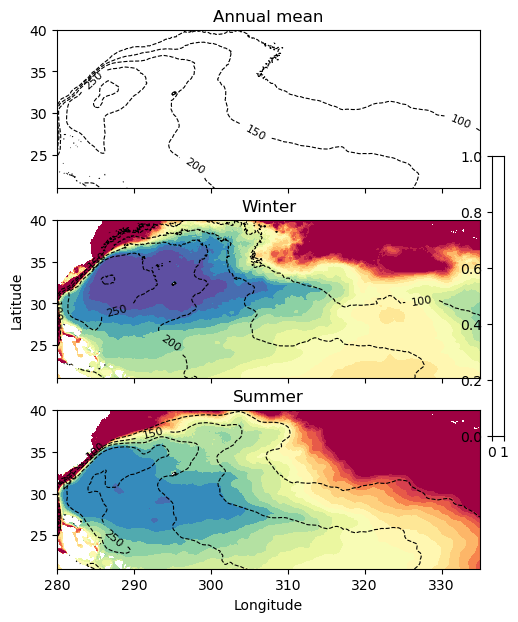

In [12]:
# cmap = plt.get_cmap('GnBu_r', 20)
# cmap = truncate_colormap(cmap, 0, 0.8)
strs = ['250', '200', '150', '100']

cmap = plt.get_cmap('Spectral_r', 20)
cmap = truncate_colormap(cmap, 0, 1)

fig, ax = plt.subplots(figsize = (6,7), nrows = 3)
plt.subplots_adjust(right = 0.83)
# fig.tight_layout()

d_index = 21
# im0 = ax[0].contourf(Pi_mean.XG, 
#                     Pi_mean.YG, 
#                     Pi_mean.isel(delta_outer = d_index), 
#                     levels=np.linspace(1e-10,1e-9,19), cmap=cmap, 
#                     extend='both'
#                     )  
ct0 = ax[0].contour(zetab_mean.XC, 
                 zetab_mean.YC, 
                 zetab_mean.isel(delta_outer = d_index),
                 levels = [-250, -200, -150, -100],
                 linewidths=0.8, colors='k')
fmt = {}
for l, s in zip(ct0.levels, strs):
    fmt[l] = s
ax[0].clabel(ct0,inline = True,
             fmt=fmt, 
             colors='k', fontsize=8)

ax[0].set_title('Annual mean')
ax[0].set_xticklabels([])
ax[0].set_xlim([280,335])
ax[0].set_ylim([21,40])

#
im1 = ax[1].contourf(Pi_spring.XG, 
                    Pi_spring.YG, 
                    Pi_spring.isel(delta_outer = d_index), 
                    levels=np.linspace(1e-10,1e-9,19), cmap=cmap, 
                    extend='both'
                    )  
ct1 = ax[1].contour(zetab_winter.XC, 
                 zetab_winter.YC, 
                 zetab_winter.isel(delta_outer = d_index),
                 levels = [-300, -250, -200, -150, -100],
                 linewidths=0.8, colors='k')
fmt = {}
for l, s in zip(ct0.levels, strs):
    fmt[l] = s
ax[1].clabel(ct1,inline = True,
             fmt=fmt, colors='k', fontsize=8)

ax[1].set_title('Winter')
ax[1].set_xticklabels([])
ax[1].set_ylabel('Latitude')
ax[1].set_xlim([280,335])
ax[1].set_ylim([21,40])

#
im2 = ax[2].contourf(Pi_autumn.XG, 
                    Pi_autumn.YG, 
                    Pi_autumn.isel(delta_outer = d_index), 
                    levels=np.linspace(1e-10,1e-9,19), cmap=cmap, 
                    extend='both'
                    )   
ct2 = ax[2].contour(zetab_summer.XC, 
                 zetab_summer.YC, 
                 zetab_summer.isel(delta_outer = d_index),
                 levels = [-300, -250, -200, -150, -100],
                 linewidths=0.8, colors='k')
fmt = {}
for l, s in zip(ct0.levels, strs):
    fmt[l] = s
ax[2].clabel(ct2,inline = True,
             fmt=fmt, colors='k', fontsize=8)

ax[2].set_title('Summer')
ax[2].set_xlabel('Longitude')
ax[2].set_xlim([280,335])
ax[2].set_ylim([21,40])

# colour bar
caxes = fig.add_axes((0.85, 0.3, 0.02, 0.4))
cbar = fig.colorbar(im0, cax = caxes,
                orientation='vertical', shrink=.7, extend = 'max')
# caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
cbar.set_label(r'$\Pi^{\#}/g$ $(\times 10^{-9})$ [m$^{-1}$s$^{-1}$]', fontsize=10)

# plt.savefig(figdir+'PV_mean.eps', format = 'eps', dpi= 600, 
#               bbox_inches = 'tight', pad_inches = 0.1)
# plt.savefig(figdir+'PV_mean.png', format = 'png', dpi= 600, 
#               bbox_inches = 'tight', pad_inches = 0.1)

# Solve Bernoulli

## Solve Bernoulli from definition $ B = (u^2+v^2)/2 + m$

In [35]:
year = years[0]

for itime in ntimes[0]:
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    grid = Grid(ds, periodic=['X'])
    dxC_r = ds.dxC ** -1 
    dyC_r = ds.dyC ** -1
    
    KE = (grid.interp(dsb.uhat ** 2, 'X') 
        + grid.interp(dsb.vhat ** 2, 'Y')
         )/2
    
    if itime == ntimes[0,0]:
        # compute dBdx, dBdy from given montgomery potential gradients
        dBdx = grid.diff(KE, 'X') * dxC_r + dsb.mbxb 
        dBdy = grid.diff(KE, 'Y') * dyC_r + dsb.mbyb 
        # compute dBdxx, dBdyy
        dBdxx = grid.interp(grid.diff(dBdx, 'X'), 'X') * dxC_r 
        dBdyy = grid.interp(grid.diff(dBdy, 'Y'), 'Y') * dyC_r
        
    else:
        dBdx_tmp = grid.diff(KE, 'X') * dxC_r + dsb.mbxb
        dBdy_tmp = grid.diff(KE, 'Y') * dyC_r + dsb.mbyb
        dBdx = xr.concat([dBdx, dBdx_tmp], 'itime')
        dBdy = xr.concat([dBdy, dBdy_tmp], 'itime')
        
        dBdxx = xr.concat([dBdxx, grid.interp(grid.diff(dBdx_tmp, 'X'), 'X') * dxC_r], 'itime')
        dBdyy = xr.concat([dBdyy, grid.interp(grid.diff(dBdy_tmp, 'Y'), 'Y') * dyC_r], 'itime')
    
    ds.close()
    dsb.close()

nabla2_B = grid.interp(dBdxx, 'Y') + grid.interp(dBdyy, 'X')


In [80]:
d_index = 2 
XG_sub = [280, 335]
YG_sub = [21,40]
mask_annual = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/annual_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )
mask_winter = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/winter_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )
mask_summer = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/summer_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )

In [81]:
d_index = 21
# annual mean
dBdx_mean = grid.interp(dBdx.mean('itime'), 'Y').isel(delta_outer = d_index
                                   ).sel(XG = mask_annual.XG, YG = mask_annual.YG)
dBdy_mean = grid.interp(dBdy.mean('itime'), 'X').isel(delta_outer = d_index
                                   ).sel(XG = mask_annual.XG, YG = mask_annual.YG)
nabla2B_mean = (nabla2_B.mean('itime')).isel(delta_outer = d_index
                                   ).sel(XG = mask_annual.XG, YG = mask_annual.YG)

# summer
dBdx_summer = grid.interp(dBdx.sel(itime = range(36,55)).mean('itime'), 'Y'
                         ).isel(delta_outer = d_index
                                   ).sel(XG = mask_summer.XG, YG = mask_summer.YG)
dBdy_summer = grid.interp(dBdy.sel(itime = range(36,55)).mean('itime'), 'X'
                       ).isel(delta_outer = d_index
                                   ).sel(XG = mask_summer.XG, YG = mask_summer.YG)
nabla2B_summer = (nabla2_B.sel(itime = range(36,55)).mean('itime')
               ).isel(delta_outer = d_index
                                   ).sel(XG = mask_summer.XG, YG = mask_summer.YG)

# winter
dBdx_winter = grid.interp(dBdx.sel(itime = range(0,18)).mean('itime'), 'Y'
                         ).isel(delta_outer = d_index
                                   ).sel(XG = mask_winter.XG, YG = mask_winter.YG)
dBdy_winter = grid.interp(dBdy.sel(itime = range(0,18)).mean('itime'), 'X'
                       ).isel(delta_outer = d_index
                                   ).sel(XG = mask_winter.XG, YG = mask_winter.YG)
nabla2B_winter = (nabla2_B.sel(itime = range(0,18)).mean('itime')
               ).isel(delta_outer = d_index
                                   ).sel(XG = mask_winter.XG, YG = mask_winter.YG)

In [82]:
solB, istop, itn, r1norm = bernoulli(nabla2B_mean.fillna(0), - dBdx_mean.fillna(0), 
                                     dBdx_mean.fillna(0), dBdy_mean.fillna(0), 
                                     - dBdy_mean.fillna(0), mask_annual)
BB = dBdx_mean * 0
tot_B_mean  = BB.where(BB !=0, solB)
print('residual for mean: ', r1norm)

solB, istop, itn, r1norm = bernoulli(nabla2B_winter.fillna(0), - dBdx_winter.fillna(0), 
                                     dBdx_winter.fillna(0), dBdy_winter.fillna(0), 
                                     - dBdy_winter.fillna(0), mask_winter)
BB = dBdx_winter * 0
tot_B_winter  = BB.where(BB !=0, solB)
print('residual for winter: ', r1norm)

solB, istop, itn, r1norm = bernoulli(nabla2B_summer.fillna(0), - dBdx_summer.fillna(0), 
                                     dBdx_summer.fillna(0), dBdy_summer.fillna(0), 
                                     - dBdy_summer.fillna(0), mask_summer)
BB = dBdx_summer * 0
tot_B_summer  = BB.where(BB !=0, solB)
print('residual for summer: ', r1norm)


residual for mean:  9.40842154450814e-09
residual for winter:  3.357776940066983e-08
residual for summer:  6.9661983239616006e-09


Save the Bernoulli solutions in the same folder where masks are saved. 

In [85]:
dsave = tot_B_mean.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/annual_tot_Ber/' 
                                        % (year)), mode='w')
dsave.close()

dsave = tot_B_winter.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/winter_tot_Ber/' 
                                        % (year)), mode='w')
dsave.close()

dsave = tot_B_summer.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/summer_tot_Ber/' 
                                        % (year)), mode='w')
dsave.close()

## Solve Bernoulli from PV flux

In [86]:
year = years[0]

for itime in ntimes[0]:    
    # read files
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    delta = .5*(dsz.delta_outer[1:].data 
                + dsz.delta_outer[:-1].data)
    dsz.coords['delta'] = ('delta',delta)

    gridz = Grid(dsz, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
           )

    buoyb = -grav * dsz.delta * rho0**-1
   
    sigmab = (dsz.dzetab * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb = (dsz.dzetaxb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb = (dsz.dzetayb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    
    grid = Grid(ds, periodic=['X'])
    dxC_r = ds.dxC ** -1 
    dyC_r = ds.dyC ** -1
    
    dsJ = xr.open_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Ju = dsJ.Ju
    Jv = dsJ.Jv
   
    dsF = xr.open_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Fu = dsF.Fu
    Fv = dsF.Fv
    
    dsG = xr.open_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Gu = dsG.Gu
    Gv = dsG.Gv
    
    if itime == ntimes[0,0]:
        # thickness-weighted flux
        JJu = Ju * sigmaxb
        JJv = Jv * sigmayb
        
        FFu = Fu * sigmaxb
        FFv = Fv * sigmayb     
         
        GGu = Gu * sigmaxb
        GGv = Gv * sigmayb
        
    else:
        JJu = xr.concat([JJu, Ju * sigmaxb], 'time')
        JJv = xr.concat([JJv, Jv * sigmayb], 'time')
        
        FFu = xr.concat([FFu, Fu * sigmaxb], 'time')
        FFv = xr.concat([FFv, Fv * sigmayb], 'time')
        
        GGu = xr.concat([GGu, Gu * sigmaxb], 'time')
        GGv = xr.concat([GGv, Gv * sigmayb], 'time')

Bernoulli is solved for each flux in annual/summer/winter mean fields

In [87]:
d_index = 2 
XG_sub = [280, 335]
YG_sub = [21,40]
mask_annual = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/annual_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )
mask_winter = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/winter_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )
mask_summer = xr.open_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/summer_PV_mask/' 
                                                % (year)
                              )).isel(delta_outer = d_index
                                     ).sel(YG = slice(YG_sub[0],YG_sub[1]), 
                                           XG = slice(XG_sub[0],XG_sub[1])
                                          )

In [88]:
def ber_from_flux(JJu_mean,JJv_mean,mask):
    
    J_XG = mask.XG
    J_YG = mask.YG
    # boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
    g_w = - grid.interp(JJv_mean, 'X').sel(
        XG = J_XG, 
        YG = J_YG)
    g_e = grid.interp(JJv_mean, 'X').sel(
        XG = J_XG, 
        YG = J_YG)
    g_n = - grid.interp(JJu_mean, 'Y').sel(
        XG = J_XG, 
        YG = J_YG)
    g_s = grid.interp(JJu_mean, 'Y').sel(
        XG = J_XG, 
        YG = J_YG)

    # RHS f = nabla2B = (dxJv - dyJu)
    f = ((grid.diff(JJv_mean * ds.dyC, 'X') 
         - grid.diff(JJu_mean * ds.dxC, 'Y')
        ) * ds.rAz ** -1).sel(
        XG = J_XG, 
        YG = J_YG)

    solJ, istopJ, itnJ, r1normJ = bernoulli(f.fillna(0), g_w.fillna(0), 
                                        g_e.fillna(0), g_n.fillna(0), 
                                        g_s.fillna(0), mask)
    BB = f * 0
    sol  = BB.where(BB !=0, solJ)
    print('residual: ', r1normJ)
    return sol  # return a data array
    

In [89]:
# time-mean PV flux
d_index = 21
print('annual mean flux')
JJu_mean = JJu.mean('time').isel(delta_outer = d_index
                                       )
JJv_mean = JJv.mean('time').isel(delta_outer = d_index
                                       )
solJ_mean = ber_from_flux(JJu_mean,JJv_mean,mask_annual)

dsave = solJ_mean.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/annual_meanPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('annual eddy flux')
FFu_mean = FFu.mean('time').isel(delta_outer = d_index
                                       )
FFv_mean = FFv.mean('time').isel(delta_outer = d_index
                                       )
solF_mean = ber_from_flux(FFu_mean,FFv_mean,mask_annual)

dsave = solF_mean.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/annual_eddyPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('annual diabatic flux')
GGu_mean = GGu.mean('time').isel(delta_outer = d_index
                                       )
GGv_mean = GGv.mean('time').isel(delta_outer = d_index
                                       )
solG_mean = ber_from_flux(GGu_mean,GGv_mean,mask_annual)

dsave = solG_mean.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/annual_diaPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

# winter
print('winter mean flux')
JJu_winter = JJu.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
JJv_winter = JJv.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
solJ_winter = ber_from_flux(JJu_winter,JJv_winter,mask_winter)

dsave = solJ_winter.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/winter_meanPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('winter eddy flux')
FFu_winter = FFu.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
FFv_winter = FFv.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
solF_winter = ber_from_flux(FFu_winter,FFv_winter,mask_winter)

dsave = solF_winter.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/winter_eddyPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('winter diabatic flux')
GGu_winter = GGu.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
GGv_winter = GGv.sel(time = range(0,18)).mean('time').isel(delta_outer = d_index
                                       )
solG_winter = ber_from_flux(GGu_winter,GGv_winter,mask_winter)

dsave = solG_winter.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/winter_diaPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

# summer 
print('summer mean flux')
JJu_summer = JJu.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                       )
JJv_summer = JJv.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                        )
solJ_summer = ber_from_flux(JJu_summer,JJv_summer,mask_summer)

dsave = solJ_summer.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/summer_meanPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('summer eddy flux')
FFu_summer = FFu.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                       )
FFv_summer = FFv.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                       )
solF_summer = ber_from_flux(FFu_summer,FFv_summer,mask_summer)

dsave = solF_summer.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/summer_eddyPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

print('summer diabatic flux')
GGu_summer = GGu.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                       )
GGv_summer = GGv.sel(time = range(36,55)).mean('time').isel(delta_outer = d_index
                                       )
solG_summer = ber_from_flux(GGu_summer,GGv_summer,mask_summer)

dsave = solG_summer.to_dataset(name='Bernoulli').chunk({'YG':ychunk,'XG':xchunk})   
dsave.to_zarr(op.join(savedir,twadir,'run%4d/Bernoulli/delta_255/summer_diaPV_Ber/' 
                                        % (year)), mode='w')
dsave.close()

annual mean flux
residual:  1.5006496715982704e-08
annual eddy flux
residual:  1.3242521628060603e-08
annual diabatic flux
residual:  1.8673004643313587e-09
winter mean flux
residual:  2.3926561945795168e-08
winter eddy flux
residual:  9.820585002704183e-08
winter diabatic flux
residual:  3.986582090768395e-09
summer mean flux
residual:  7.277138941855774e-09
summer eddy flux
residual:  1.7697545481828695e-09
summer diabatic flux
residual:  5.516277955029612e-11


## Plots of solutions

Text(0.5, 1.0, 'Summer')

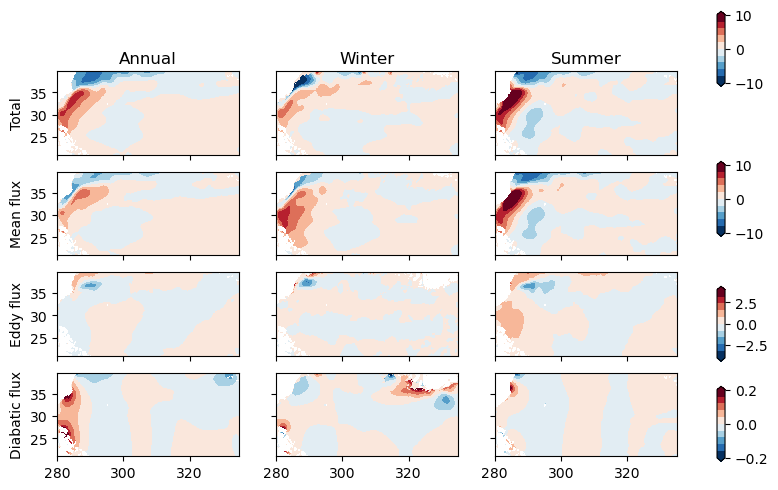

In [93]:
fig, ax = plt.subplots(figsize=(8,5),nrows = 4, ncols = 3)

cmap = plt.get_cmap('RdBu_r', 10)

## total Ber
im00 = ax[0,0].pcolormesh(tot_B_mean.XG, tot_B_mean.YG, 
                   tot_B_mean,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct00 = ax[0,0].contour(Pi_mean.XG, 
#                  Pi_mean.YG, 
#                  Pi_mean*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[0,0].clabel(ct00, fmt='%2.1f', colors='k', fontsize=8)

im01 = ax[0,1].pcolormesh(tot_B_winter.XG, tot_B_winter.YG, 
                   tot_B_winter,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct01 = ax[0,1].contour(Pi_winter.XG, 
#                  Pi_winter.YG, 
#                  Pi_winter*1e10,
#                  levels = [2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[0,1].clabel(ct01, fmt='%2.1f', colors='k', fontsize=8)


im02 = ax[0,2].pcolormesh(tot_B_summer.XG, tot_B_summer.YG, 
                   tot_B_summer,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct02 = ax[0,2].contour(Pi_summer.XG, 
#                  Pi_summer.YG, 
#                  Pi_summer*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[0,2].clabel(ct02, fmt='%2.1f', colors='k', fontsize=8)

caxes = fig.add_axes((0.95, 0.85, 0.01, 0.15))
cbar = fig.colorbar(im02, cax = caxes,
                orientation='vertical', shrink=.7, extend = 'both')

# caxes.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0, 1.25])
# cbar.set_label(r'$\overline{\mathcal{B}}^t$', fontsize=10)

# mean PV
im00 = ax[1,0].pcolormesh(solJ_mean.XG, solJ_mean.YG, 
                   solJ_mean,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct00 = ax[1,0].contour(Pi_mean.XG, 
#                  Pi_mean.YG, 
#                  Pi_mean*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[1,0].clabel(ct00, fmt='%2.1f', colors='k', fontsize=8)

im01 = ax[1,1].pcolormesh(solJ_winter.XG, solJ_winter.YG, 
                   solJ_winter,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct01 = ax[1,1].contour(Pi_winter.XG, 
#                  Pi_winter.YG, 
#                  Pi_winter*1e10,
#                  levels = [2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[1,1].clabel(ct01, fmt='%2.1f', colors='k', fontsize=8)


im02 = ax[1,2].pcolormesh(solJ_summer.XG, solJ_summer.YG, 
                   solJ_summer,
                vmin = -10, vmax = 10, rasterized=True, cmap =cmap)
# ct02 = ax[1,2].contour(Pi_summer.XG, 
#                  Pi_summer.YG, 
#                  Pi_summer*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[1,2].clabel(ct02, fmt='%2.1f', colors='k', fontsize=8)

caxes = fig.add_axes((0.95, 0.55, 0.01, 0.15))
cbar = fig.colorbar(im02, cax = caxes,
                orientation='vertical', shrink=.7, extend = 'both')

# eddy 
im00 = ax[2,0].pcolormesh(solF_mean.XG, solF_mean.YG, 
                   solF_mean,
                vmin = -4, vmax = 4, rasterized=True, cmap =cmap)
# ct00 = ax[2,0].contour(Pi_mean.XG, 
#                  Pi_mean.YG, 
#                  Pi_mean*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[2,0].clabel(ct00, fmt='%2.1f', colors='k', fontsize=8)

im01 = ax[2,1].pcolormesh(solF_winter.XG, solF_winter.YG, 
                   solF_winter,
                vmin = -4, vmax = 4, rasterized=True, cmap =cmap)
# ct01 = ax[2,1].contour(Pi_winter.XG, 
#                  Pi_winter.YG, 
#                  Pi_winter*1e10,
#                  levels = [2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[2,1].clabel(ct01, fmt='%2.1f', colors='k', fontsize=8)


im02 = ax[2,2].pcolormesh(solF_summer.XG, solF_summer.YG, 
                   solF_summer,
                vmin = -4, vmax = 4, rasterized=True, cmap =cmap)
# ct02 = ax[2,2].contour(Pi_summer.XG, 
#                  Pi_summer.YG, 
#                  Pi_summer*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[2,2].clabel(ct02, fmt='%2.1f', colors='k', fontsize=8)

caxes = fig.add_axes((0.95, 0.3, 0.01, 0.15))
cbar = fig.colorbar(im02, cax = caxes,
                orientation='vertical', shrink=.7, extend = 'both')

# diabatic 
im00 = ax[3,0].pcolormesh(solG_mean.XG, solG_mean.YG, 
                   solG_mean,
                vmin = -0.2, vmax = 0.2, rasterized=True, cmap =cmap)
# ct00 = ax[3,0].contour(Pi_mean.XG, 
#                  Pi_mean.YG, 
#                  Pi_mean*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[3,0].clabel(ct00, fmt='%2.1f', colors='k', fontsize=8)

im01 = ax[3,1].pcolormesh(solG_winter.XG, solG_winter.YG, 
                   solG_winter,
                vmin = -0.2, vmax = 0.2, rasterized=True, cmap =cmap)
# ct01 = ax[3,1].contour(Pi_winter.XG, 
#                  Pi_winter.YG, 
#                  Pi_winter*1e10,
#                  levels = [2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[3,1].clabel(ct01, fmt='%2.1f', colors='k', fontsize=8)


im02 = ax[3,2].pcolormesh(solG_summer.XG, solG_summer.YG, 
                   solG_summer,
                vmin = -0.2, vmax = 0.2, rasterized=True, cmap =cmap)
# ct02 = ax[3,2].contour(Pi_summer.XG, 
#                  Pi_summer.YG, 
#                  Pi_summer*1e10,
#                  levels = [1.7, 2.0, 2.3, 2.5],
#                  linewidths=0.8, colors='k')
# ax[3,2].clabel(ct02, fmt='%2.1f', colors='k', fontsize=8)

caxes = fig.add_axes((0.95, 0.1, 0.01, 0.15))
cbar = fig.colorbar(im02, cax = caxes,
                orientation='vertical', shrink=.7, extend = 'both')

# labels, axis and titles
for index in [1,2]:
    for n in range(4):
        ax[n,index].set_yticklabels([])
for index in [0,1,2]:
    for n in range(3):
        ax[index,n].set_xticklabels([])

ax[0,0].set_ylabel('Total')
ax[1,0].set_ylabel('Mean flux')
ax[2,0].set_ylabel('Eddy flux')
ax[3,0].set_ylabel('Diabatic flux')

ax[0,0].set_title('Annual')
ax[0,1].set_title('Winter')
ax[0,2].set_title('Summer')

# plt.savefig(figdir+'bernouli_1967.eps', format = 'eps', dpi= 600, 
#                bbox_inches = 'tight', pad_inches = 0.1)


# Reconstruct fluxes from Bernoulli

Next time, remember to read file for mask_annual first.

In [77]:
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
grid = Grid(ds.sel(XC = mask_annual.XG.values, XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, YG = mask_annual.YG.values, 
                       method = 'nearest'),
                    coords={'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
               )
dyG = ds.dyG.sel(XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest')
dxG = ds.dxG.sel(XC = mask_annual.XG.values,
                       YG = mask_annual.YG.values, 
                       method = 'nearest')
rAs = ds.rAs.sel(XC = mask_annual.XG.values,
                       YG = mask_annual.YG.values, 
                       method = 'nearest')
rAw = ds.rAw.sel(XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest')

In [82]:
for itime in ntimes[0]:    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                                   % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               ).reset_coords(drop=True)

    delta = .5*(dsz.delta_outer[1:].data 
                + dsz.delta_outer[:-1].data)
    dsz.coords['delta'] = ('delta',delta)

    gridz = Grid(dsz, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
           )

    buoyb = -grav * dsz.delta * rho0**-1

    sigmab_tmp = (dsz.dzetab * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb_tmp = (dsz.dzetaxb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb_tmp = (dsz.dzetayb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)

    if itime == ntimes[0,0]:
            sigmaxb  = sigmaxb_tmp
            sigmayb  = sigmayb_tmp
            sigmab  = sigmab_tmp

    else:
            sigmaxb = xr.concat([sigmaxb, sigmaxb_tmp], 'itime')
            sigmayb = xr.concat([sigmayb, sigmayb_tmp], 'itime')
            sigmab = xr.concat([sigmab, sigmab_tmp], 'itime')
    dsz.close()

sigmaxb_mean = sigmaxb.mean('itime').isel(delta_outer = d_index
                                       ).sel(XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest')
sigmayb_mean = sigmayb.mean('itime').isel(delta_outer = d_index
                                       ).sel(XC = mask_annual.XG.values,
                       YG = mask_annual.YG.values, 
                       method = 'nearest')
sigmab_mean = sigmab.mean('itime').isel(delta_outer = d_index
                                       ).sel(XC = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest')


In [94]:
B_field = solJ_mean

dx_B_field = grid.diff(grid.interp(dyG,'Y') * B_field, 'X') * rAs ** -1
dy_B_field = grid.diff(grid.interp(dxG,'X') * B_field, 'Y') * rAw ** -1

re_flux_u = - dy_B_field #* sigmaxb_mean ** -1
re_flux_v = dx_B_field #* sigmayb_mean ** -1 #JJu_mean has been thickness weighted

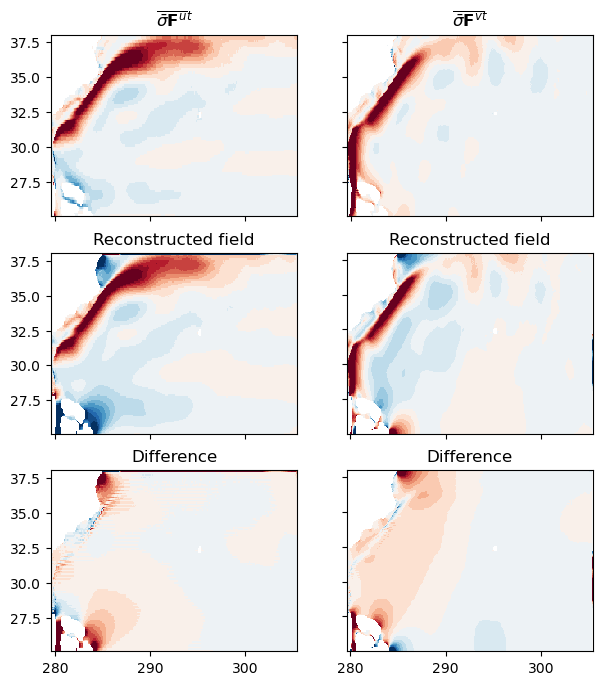

In [105]:
fig1, ax1 = plt.subplots(figsize=(7,8),nrows = 3, ncols = 2)
cmap = plt.get_cmap('RdBu_r', 20)
ax00 = ax1[0,0].pcolormesh(mask_annual.XG, mask_annual.YG, 
                JJu_mean.sel(XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest'),
                           vmin = -5e-5, vmax = 5e-5, cmap = cmap)

ax1[0,0].set_title(r'$\overline{\bar{\sigma}\mathbf{F}^u}^t$') 


ax00 = ax1[0,1].pcolormesh(mask_annual.XG, mask_annual.YG, 
                JJv_mean.sel(XC = mask_annual.XG.values,
                       YG = mask_annual.YG.values, 
                       method = 'nearest'),
                           vmin = -5e-5, vmax = 5e-5, cmap = cmap)

ax1[0,1].set_title(r'$\overline{\bar{\sigma}\mathbf{F}^v}^t$') 

ax00 = ax1[1,0].pcolormesh(re_flux_u.XG, re_flux_u.YC, 
                            re_flux_u,
                           vmin = -5e-5, vmax = 5e-5, cmap = cmap)

ax1[1,0].set_title(r'Reconstructed field') 

ax00 = ax1[1,1].pcolormesh(re_flux_v.XC, re_flux_v.YG, 
                            re_flux_v,
                           vmin = -5e-5, vmax = 5e-5, cmap = cmap)

ax1[1,1].set_title(r'Reconstructed field') 


ax00 = ax1[2,0].pcolormesh(re_flux_u.XG, re_flux_u.YC, 
                            JJu_mean.sel(XG = mask_annual.XG.values,
                       YC = mask_annual.YG.values, 
                       method = 'nearest') - re_flux_u,
                         vmin = -5e-5, vmax = 5e-5,  cmap = cmap)

ax1[2,0].set_title(r'Difference') 

ax00 = ax1[2,1].pcolormesh(re_flux_v.XC, re_flux_v.YG, 
                            JJv_mean.sel(XC = mask_annual.XG.values,
                       YG = mask_annual.YG.values, 
                       method = 'nearest') - re_flux_v,
                          vmin = -5e-5, vmax = 5e-5, cmap = cmap)

ax1[2,1].set_title(r'Difference') 


for index in [1]:
    for n in range(3):
        ax1[n,index].set_yticklabels([])
for index in [0,1]:
    for n in range(2):
        ax1[index,n].set_xticklabels([])

plt.savefig(figdir+'reconstruct_meanPV_flux.eps', format = 'eps', dpi= 600, 
               bbox_inches = 'tight', pad_inches = 0.1)

# Illustrations

## Bernoulli fields

Later need to read solutions of Bernoulli and masks too

## old codes

In [36]:
# time-mean PV flux        
JJu_mean = JJu.mean('itime')
JJv_mean = JJv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g_w = - grid.interp(JJv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g_e = grid.interp(JJv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g_n = - grid.interp(JJu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g_s = grid.interp(JJu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))

# RHS f = nabla2B = (dxJv - dyJu)
f = ((grid.diff(JJv_mean * ds.dyC, 'X') 
     - grid.diff(JJu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))

solJ, istopJ, itnJ, r1normJ = bernoulli(f, g_w, g_e, g_n, g_s, hx2, hy2)

print('residual J flux: ', r1normJ)

# time-mean eddy flux        
FFu_mean = FFu.mean('itime')
FFv_mean = FFv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g2_w = - grid.interp(FFv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g2_e = grid.interp(FFv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1])).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1])).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g2_n = - grid.interp(FFu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1])).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g2_s = grid.interp(FFu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))

# RHS f = nabla2B = (dxJv - dyJu)
f2 = ((grid.diff(FFv_mean * ds.dyC, 'X') 
     - grid.diff(FFu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))

solF, istopF, itnF, r1normF = bernoulli(f2, g2_w, g2_e, g2_n, g2_s, hx2, hy2)

print('residual F flux: ', r1normF)

# time-mean eddy flux        
GGu_mean = GGu.mean('itime')
GGv_mean = GGv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g3_w = - grid.interp(GGv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g3_e = grid.interp(GGv_mean, 'X').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g3_n = - grid.interp(GGu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))
g3_s = grid.interp(GGu_mean, 'Y').sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))

# RHS f = nabla2B = (dxJv - dyJu)
f3 = ((grid.diff(GGv_mean * ds.dyC, 'X') 
     - grid.diff(GGu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = slice(XG_sub[0],XG_sub[1]), 
    YG = slice(YG_sub[0],YG_sub[1]))


solG, istopG, itnG, r1normG = bernoulli(f3, g3_w, g3_e, g3_n, g3_s, hx2, hy2)
print('residual G flux: ', r1normG)

residual J flux:  6.623663022327284e-10
residual F flux:  8.140397172245788e-11
residual G flux:  9.312916395433166e-12


<Figure size 640x480 with 0 Axes>

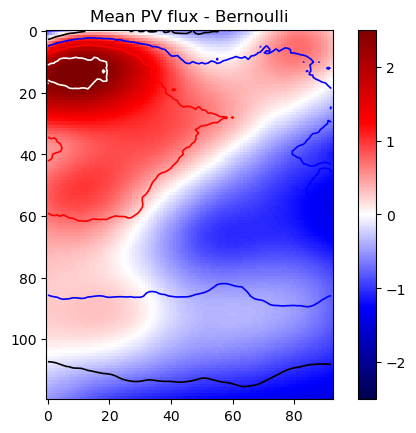

<Figure size 640x480 with 0 Axes>

In [59]:
plt.imshow(np.flip(solJ,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.contour(np.flip(Pi_mean,0),
         levels = [1.5e-10,1.7e-10,2e-10,2.5e-10],
         linewidths=1.2, colors=['w','r','b','k'])
plt.title('Mean PV flux - Bernoulli')
plt.figure()

<Figure size 640x480 with 0 Axes>

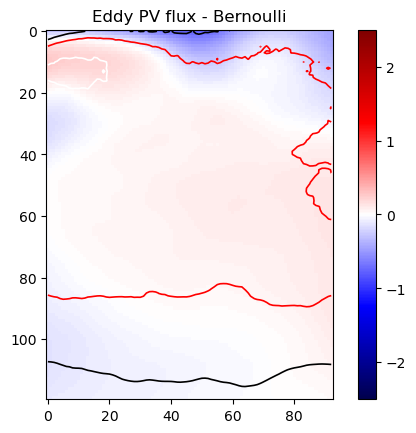

<Figure size 640x480 with 0 Axes>

In [60]:
plt.imshow(np.flip(solF,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.contour(np.flip(Pi_mean,0),
         levels = [1.5e-10,2e-10,2.5e-10],
         linewidths=1.2, colors=['w','r','k'])
plt.title('Eddy PV flux - Bernoulli')
plt.figure()

<Figure size 640x480 with 0 Axes>

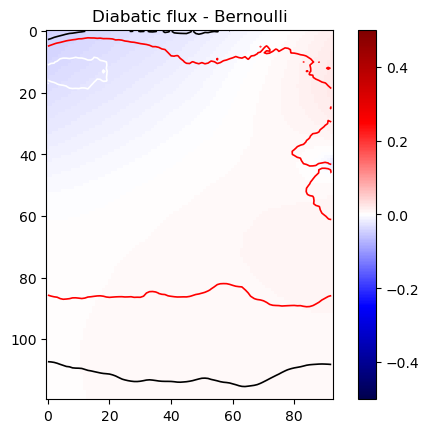

<Figure size 640x480 with 0 Axes>

In [53]:

plt.imshow(np.flip(solG,0),cmap = 'seismic')
plt.colorbar()
plt.title('Diabatic flux - Bernoulli')
plt.clim([-.5, .5])
plt.contour(np.flip(Pi_mean,0),
         levels = [1.5e-10,2e-10,2.5e-10],
         linewidths=1.2, colors=['w','r','k'])
plt.figure()

<Figure size 640x480 with 0 Axes>

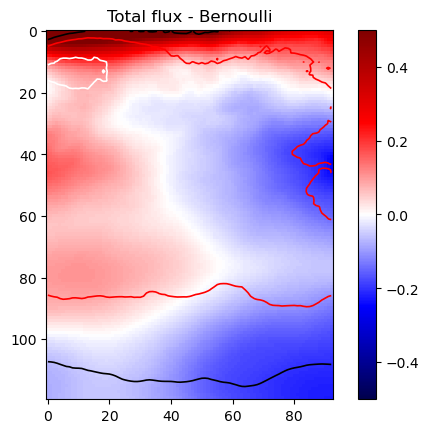

<Figure size 640x480 with 0 Axes>

In [56]:

plt.imshow(np.flip(solF+solJ+solG-solB,0),cmap = 'seismic')
plt.colorbar()
plt.title('Total flux - Bernoulli')
plt.clim([-.5, .5])
plt.contour(np.flip(Pi_mean,0),
         levels = [1.5e-10,2e-10,2.5e-10],
         linewidths=1.2, colors=['w','r','k'])
plt.figure()

## illustration at delta_outer = 21, X = 287-295, Y = 26 - 36

In [65]:
Pi_mean

<xarray.DataArray 'Pi' (YG: 120, XG: 93)>
dask.array<mean_agg-aggregate, shape=(120, 93), dtype=float64, chunksize=(120, 93), chunktype=numpy.ndarray>
Coordinates:
  * XG           (XG) float32 287.0 287.1 287.2 287.3 ... 294.7 294.8 294.9
  * YG           (YG) float32 26.04 26.13 26.21 26.29 ... 35.79 35.88 35.96
    delta_outer  float64 25.49

In [120]:
xrange = np.arange(287,295,93)
xrange

array([287])

In [129]:
# transfer np arrays to data arrays
solB = Pi_mean.where(Pi_mean ==0, solB).rename('Bernoulli')
solF = Pi_mean.where(Pi_mean ==0, solF).rename('Bernoulli')
solJ = Pi_mean.where(Pi_mean ==0, solJ).rename('Bernoulli')
solG = Pi_mean.where(Pi_mean ==0, solG).rename('Bernoulli')

Text(0.5, 1.0, 'relative difference')

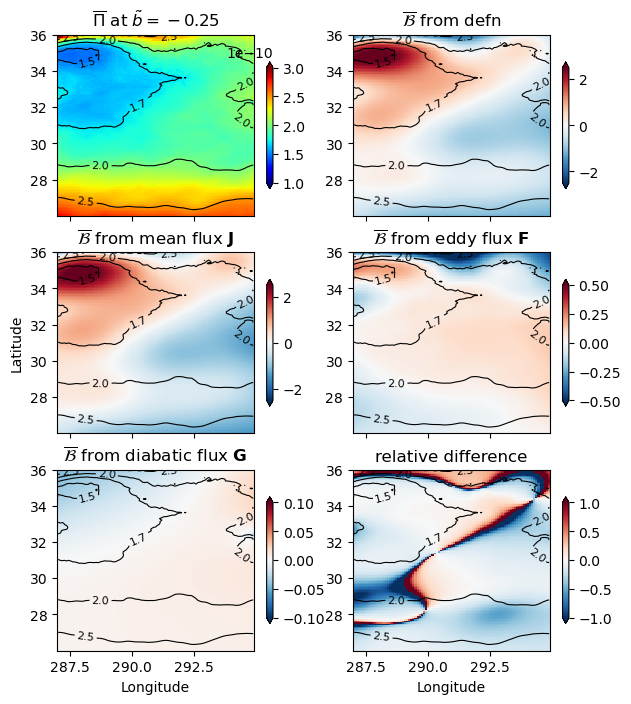

In [165]:
fig1, ax1 = plt.subplots(figsize=(7,8),nrows = 3, ncols = 2)
ax00 = ax1[0,0].pcolormesh(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean,vmin = 1e-10, vmax = 3e-10, cmap = 'jet')
ct00 = ax1[0,0].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[0,0].clabel(ct00, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax00, 
             extend = 'both', shrink = 0.7)
# cbar.ax1[0,0].set_yticklabels([1, 1.5, 2, 2.5, 3])
ax1[0,0].set_title(r'$\overline{\Pi}$ at $\tilde{b} = -0.25$') 
# ax1[0,0].set_xlabel('Latitude')
# ax1[0,0].set_ylabel('Longitude')


ax01 = ax1[0,1].pcolormesh(solB.XG, solB.YG, 
                solB,vmin = -2.5, vmax = 2.5, cmap = 'RdBu_r')
ct01 = ax1[0,1].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[0,1].clabel(ct01, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax01, 
             extend = 'both', shrink = 0.7)
ax1[0,1].set_title(r'$\overline{\mathcal{B}}$ from defn')


ax10 = ax1[1,0].pcolormesh(solJ.XG, solJ.YG, 
                solJ,vmin = -2.5, vmax = 2.5, cmap = 'RdBu_r')
ct10 = ax1[1,0].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[1,0].clabel(ct10, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax10, 
             extend = 'both', shrink = 0.7)
ax1[1,0].set_title(r'$\overline{\mathcal{B}}$ from mean flux $\mathbf{J}$')


ax11 = ax1[1,1].pcolormesh(solF.XG, solF.YG, 
                solF,vmin = -.5, vmax = .5, cmap = 'RdBu_r')
ct11 = ax1[1,1].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[1,1].clabel(ct11, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax11, 
             extend = 'both', shrink = 0.7)
ax1[1,1].set_title(r'$\overline{\mathcal{B}}$ from eddy flux $\mathbf{F}$')


ax20 = ax1[2,0].pcolormesh(solG.XG, solG.YG, 
                solG,vmin = -.1, vmax = .1, cmap = 'RdBu_r')
ct20 = ax1[2,0].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[2,0].clabel(ct20, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax20, 
             extend = 'both', shrink = 0.7)
ax1[2,0].set_title(r'$\overline{\mathcal{B}}$ from diabatic flux $\mathbf{G}$')


for index in [0,1]:
    ax1[index,0].set_xticklabels([])
    ax1[index,1].set_xticklabels([])
ax1[2,0].set_xlabel('Longitude')
ax1[2,1].set_xlabel('Longitude')
ax1[1,0].set_ylabel('Latitude')

ax21 = ax1[2,1].pcolormesh(solG.XG, solG.YG, 
                (solB-solJ-solF-solG)/solB,
                           vmin = -1, vmax =1, cmap = 'RdBu_r')
ct21 = ax1[2,1].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax1[2,1].clabel(ct21, fmt='%2.1f', colors='k', fontsize=8)
fig1.colorbar(ax21, 
             extend = 'both', shrink = 0.7)
ax1[2,1].set_title('relative difference')

In [166]:
fig1.savefig(figdir+'Bernoulli_b25.eps', format = 'eps', dpi= 600, 
            bbox_inches = 'tight', pad_inches = 0.1)

## pick a point on 2e-10

In [177]:
print(Pi_mean.sel(XG = 292.75, YG = 35.5, method = 'nearest').values)

2.0318723344852398e-10


In [179]:
print(Pi_mean.sel(XG = 292, YG = 35.2, method = 'nearest').values)
print(solB.sel(XG = 292, YG = 35.2, method = 'nearest').values)
print(solJ.sel(XG = 292, YG = 35.2, method = 'nearest').values)
print(solF.sel(XG = 292, YG = 35.2, method = 'nearest').values)
print(solG.sel(XG = 292, YG = 35.2, method = 'nearest').values)


2.014892078520401e-10
-0.2547270936509853
0.06894955773455783
-0.23702021241133392
-0.007074673755867999


In [238]:
print(Pi_mean.sel(XG = 290, YG = 28.9, method = 'nearest').values)
print(Pi_mean.sel(XG = 290, YG = 28.9, method = 'nearest'))

2.0073480671164781e-10
<xarray.DataArray 'Pi' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    XG           float32 290.0
    YG           float32 28.88
    delta_outer  float64 25.49


In [239]:
xrange = [294, 291.1, 294.5, 287.9,290]
yrange = [35.38, 35.13, 31.21, 35.72, 28.88]
pval = [2.01, 2.01, 2.0, 1.9, 2]

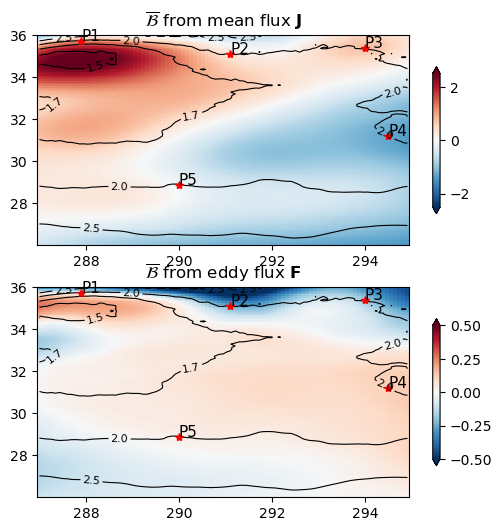

In [247]:
fig2, ax2 = plt.subplots(figsize = (6,6), nrows = 2, ncols = 1)
im1 = ax2[0].pcolormesh(solJ.XG, solJ.YG, 
                solJ,vmin = -2.5, vmax = 2.5, cmap = 'RdBu_r')
cm1 = ax2[0].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax2[0].clabel(cm1, fmt='%2.1f', colors='k', fontsize=8)
fig2.colorbar(im1, 
              extend = 'both', shrink = 0.7)
ax2[0].set_title(r'$\overline{\mathcal{B}}$ from mean flux $\mathbf{J}$')

im2 = ax2[1].pcolormesh(solF.XG, solF.YG, 
                solF,vmin = -.5, vmax = .5, cmap = 'RdBu_r')
cm2 = ax2[1].contour(Pi_mean.XG, Pi_mean.YG, 
                Pi_mean*1e10,
         levels = [1.5,1.7,2,2.5],
         linewidths=.8, colors='k')
ax2[1].clabel(cm2, fmt='%2.1f', colors='k', fontsize=8)
fig2.colorbar(im2, 
              extend = 'both', shrink = 0.7)
ax2[1].set_title(r'$\overline{\mathcal{B}}$ from eddy flux $\mathbf{F}$')
    
ax2[0].plot(xrange,yrange,'r*')
ax2[1].plot(xrange,yrange,'r*')
ii = 0
label = ['P3', 'P2', 'P4', 'P1', 'P5']
for x, y in zip(xrange, yrange):
    ax2[0].text(x, y, label[ii], fontsize=11)
    ax2[1].text(x, y, label[ii], fontsize=11)
    ii+=1

In [250]:
fig2.savefig(figdir+'Bernoulli_points_b25.eps', format = 'eps', dpi= 600, 
            bbox_inches = 'tight', pad_inches = 0.1)

In [289]:
B_values = np.zeros([len(xrange),4])
ii = 0
for i in [3,1,0,2,4]:
    
    B_values[ii, 0] = solB.sel(XG = xrange[i], YG = yrange[i], method = 'nearest').values
    B_values[ii, 1] = solJ.sel(XG = xrange[i], YG = yrange[i], method = 'nearest').values
    B_values[ii, 2] = solF.sel(XG = xrange[i], YG = yrange[i], method = 'nearest').values
    B_values[ii, 3] = solG.sel(XG = xrange[i], YG = yrange[i], method = 'nearest').values
  
    ii += 1

Task exception was never retrieved
future: <Task finished name='Task-73153' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py:2176> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/lsun/.conda/envs/modewater/lib/python3.9/site-packages/distributed/client.py", line 2185, in wait
    raise AllExit()
distributed.client.AllExit


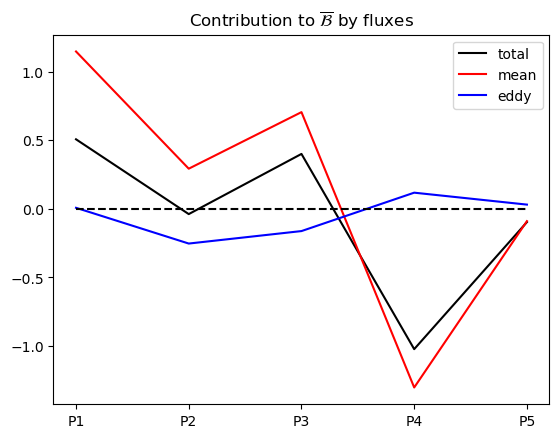

In [299]:
fig4 = plt.plot(range(5), B_values[:,0], color = 'k' ,label = 'total')
fig4 = plt.plot(range(5), B_values[:,1], color = 'r' ,label = 'mean')
fig4 =plt.plot(range(5), B_values[:,2], color = 'b' ,label = 'eddy')
fig4 =plt.plot(range(5), [0]*5, 'k--' )
plt.xticks(range(5), ['P1', 'P2', 'P3', 'P4', 'P5'])
plt.title('Contribution to $\overline{\mathcal{B}}$ by fluxes')
plt.legend()
fig4

In [300]:
fig4.savefig(figdir+'Bernoulli_contribution_b25.eps', format = 'eps', dpi= 600, 
            bbox_inches = 'tight', pad_inches = 0.1)

AttributeError: 'list' object has no attribute 'savefig'

In [303]:
B_values = B_values[[3,1,0,2,4],:]

In [304]:
B_values_ratio = 

array([[-1.02480988, -1.30455228,  0.11697936,  0.00873744],
       [-0.0393584 ,  0.292007  , -0.25429462, -0.01360358],
       [ 0.50647092,  1.1473097 ,  0.00656711, -0.03898864],
       [ 0.39977887,  0.70474715, -0.16325265,  0.00935656],
       [-0.0978057 , -0.09089418,  0.02988785,  0.00515369]])